<a href="https://colab.research.google.com/github/hulefei/AI-Notebook/blob/main/z_dreambooth_train_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title 准备

#@markdown - Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader
!echo "============================================"
!nvcc -V

#@markdown - Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

/bin/bash: nvidia-smi: command not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Mounted at /content/drive


# Dreambooth fine-tuning for Stable Diffusion using d🧨ffusers 

This notebook shows how to "teach" Stable Diffusion a new concept via Dreambooth using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

![Dreambooth Example](https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg)
_By using just 3-5 images you can teach new concepts to Stable Diffusion and personalize the model on your own images_ 

Differently from Textual Inversion, this approach trains the whole model, which can yield better results to the cost of bigger models.

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

# 安装python库

In [4]:
#@title 安装 python lib
#@title Install the required libs

!wget -q https://github.com/hulefei/zdiffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/hulefei/zdiffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/hulefei/zdiffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers
# %pip install -qq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
#@title 导入头文件和定义全局函数 

#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

# import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [6]:
#@title 登录 Huggingface

!pip install --upgrade huggingface_hub

from huggingface_hub import login
token = ""#@param {type:"string"}
login(token)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# 变量

In [56]:
#@title 训练使用变量参数
session_name = "test-rabbit" #@param {type:"string"}
#@markdown - 如果填写则根目录为drive/MyDrive/ZDreambooth/{session_name}, 否在为content

instance_prompt = "photo of test rabbit" #@param {type:"string"}
#@markdown - 需要训练的prompt

class_prompt = "photo of a rabbit" #@param {type:"string"}
#@markdown - 训练的对照prompt

save_sample_prompt = "photot of test rabbit in a gress" #@param {type:"string"}
save_sample_prompt_var = save_sample_prompt.replace(" ", "\\ ")
#@markdown - 训练的sample prompt

pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
#@markdown - 基础模型respid

dataset_model_name = "hulefei/test-model" #@param["hulefei/test-model"] {type:"string", allow-input:false}
#@markdown - dataset repoid

dataset_dir = "rabbit" #@param["cat", "corgi", "rabbit"] {type:"string", allow-input:false}
#@markdown - dataset 目录

save_to_hf = "all" #@param "simple" ["none", "simple", "all"] {allow-input:false}
#@markdown - 是否上传到huggingface（上传HF需要填写session_name）
#@markdown - none：不上传
#@markdown - simple：最后一个weight和instance图片
#@markdown - all：上传所有weight和class图

output_dir = ""

if len(session_name) == 0:
  output_dir = "/content/ZDreambooth"
else:
  output_dir = f"/content/drive/MyDrive/ZDreambooth/{session_name}"

#存放weight目录
weights_dir = f"{output_dir}/weights"

#dataset 数据
instance_data_dir = f"{output_dir}/instance_data_dir"

#class 数据
class_data_dir = f"{output_dir}/class_data_dir"

print(f"output_dir:{output_dir}")
print(f"instance_data_dir:{output_dir}")
print(f"class_data_dir:{output_dir}")
print(f"weights_dir:{weights_dir}")


output_dir:/content/drive/MyDrive/ZDreambooth/test-rabbit
instance_data_dir:/content/drive/MyDrive/ZDreambooth/test-rabbit
class_data_dir:/content/drive/MyDrive/ZDreambooth/test-rabbit
weights_dir:/content/drive/MyDrive/ZDreambooth/test-rabbit/weights


In [16]:
#@title 训练使用常量参数(不需要修改)

pretrained_vae_name_or_path = "stabilityai/sd-vae-ft-mse" #@param["stabilityai/sd-vae-ft-mse"] {type:"string", allow-input:false}
revision = "fp16" #@param["fp16"] {type:"string", allow-input:false}
prior_loss_weight = "1.0" #@param["1.0"] {type:"string", allow-input:false}
train_seed = "1337" #@param["1337"] {type:"string", allow-input:false}
resolution = "512" #@param["512"] {type:"string", allow-input:false}
train_batch_size = "1" #@param["1"] {type:"string", allow-input:false}
mixed_precision = "fp16" #@param["fp16"] {type:"string", allow-input:false}
gradient_accumulation_steps = "1" #@param["1"] {type:"string", allow-input:false}
learning_rate = "1e-6" #@param["1e-6"] {type:"string", allow-input:false}
lr_scheduler = "constant" #@param["constant"] {type:"string", allow-input:false}
lr_warmup_steps = "0" #@param["0"] {type:"string", allow-input:false}
num_class_images = "50" #@param["50"] {type:"string", allow-input:false}
sample_batch_size = "4" #@param["4"] {type:"string", allow-input:false}
max_train_steps = "800" #@param["800"] {type:"string", allow-input:false} 
save_interval = "400" #@param["400"] {type:"string", allow-input:false}

In [17]:
#@title 测试使用参数
weight_name = "800" #@param {type:"string"}

seed = -1 #@param {type:"number"}

prompt = "photo of test rabbit in a doghouse" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 6 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

# 预处理

In [ ]:
#@title 删除已经存在的session
import os

delete_session = False #@param {type:"boolean"}

if delete_session and os.path.exists(output_dir):
      shutil.rmtree(output_dir)
      print("delete success")

In [ ]:
#@title 创建 concepts_list.json
concepts_list = [
  {
    "instance_prompt" : instance_prompt,
    "class_prompt" : class_prompt,
    "instance_data_dir" : instance_data_dir,
    "class_data_dir" : class_data_dir
  }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

print(concepts_list)

[{'instance_prompt': 'photo of test rabbit', 'class_prompt': 'photo of a rabbit', 'instance_data_dir': '/content/drive/MyDrive/ZDreambooth/test-rabbit/instance_data_dir', 'class_data_dir': '/content/drive/MyDrive/ZDreambooth/test-rabbit/class_data_dir'}]


In [ ]:
#@title 构建dataset
from huggingface_hub import snapshot_download
import shutil

local_dir = f"/content/dataset/{dataset_model_name}"

snapshot_download(repo_id=dataset_model_name,
        repo_type="dataset",
        local_dir=local_dir)

if os.path.exists(instance_data_dir):
      shutil.rmtree(instance_data_dir)

shutil.copytree(f"{local_dir}/{dataset_dir}", instance_data_dir)

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

'/content/drive/MyDrive/ZDreambooth/test-rabbit/instance_data_dir'

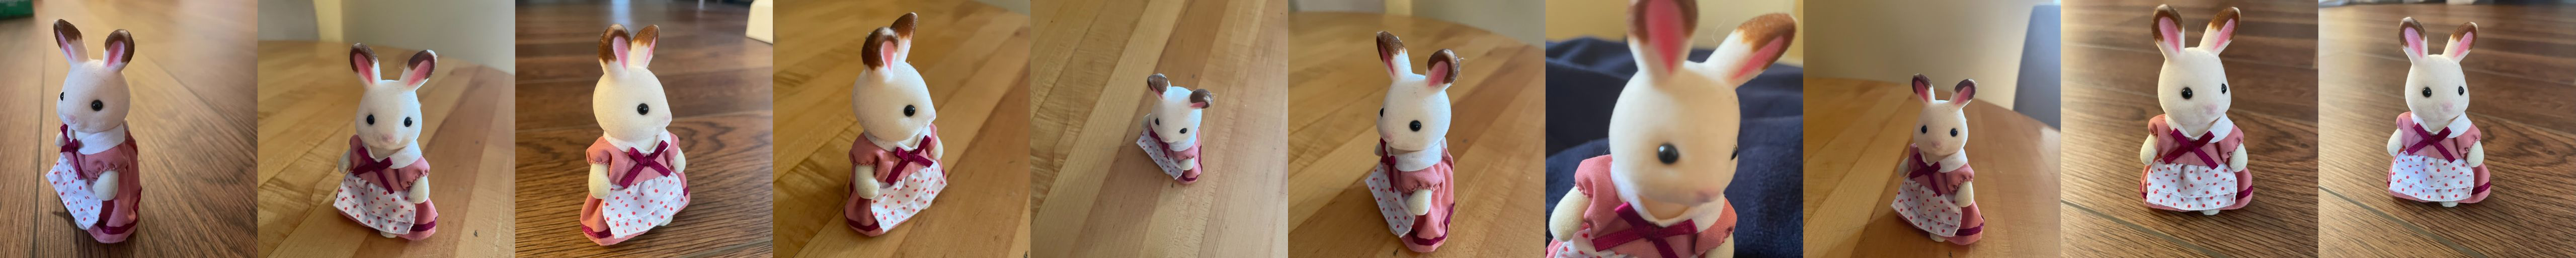

In [45]:
#@title 查看instance
import os
from PIL import Image 

image_files = os.listdir(instance_data_dir)
images = [Image.open(f"{instance_data_dir}/{f}") for f in image_files]
images_grid = image_grid(images, 1, len(images))
images_grid.save(output_dir + "/instances.jpg")
images_grid.show()

# 训练

In [ ]:
#@title 训练

!echo $save_sample_prompt_var

!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$pretrained_model_name_or_path \
  --pretrained_vae_name_or_path=$pretrained_vae_name_or_path \
  --output_dir=$weights_dir \
  --revision=$revision \
  --with_prior_preservation \
  --prior_loss_weight=$prior_loss_weight \
  --seed=$train_seed \
  --resolution=$resolution \
  --train_batch_size=$train_batch_size \
  --train_text_encoder \
  --mixed_precision=$mixed_precision \
  --use_8bit_adam \
  --gradient_accumulation_steps=$gradient_accumulation_steps \
  --learning_rate=$learning_rate \
  --lr_scheduler=$lr_scheduler \
  --lr_warmup_steps=$lr_warmup_steps \
  --num_class_images=$num_class_images \
  --sample_batch_size=$sample_batch_size \
  --max_train_steps=$max_train_steps \
  --save_interval=$save_interval \
  --save_sample_prompt=$save_sample_prompt_var \
  --concepts_list="concepts_list.json"

[[<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]]
/content/drive/MyDrive/ZDreambooth/test-rabbit/weights/400/samples
/content/drive/MyDrive/ZDreambooth/test-rabbit/weights/800/samples


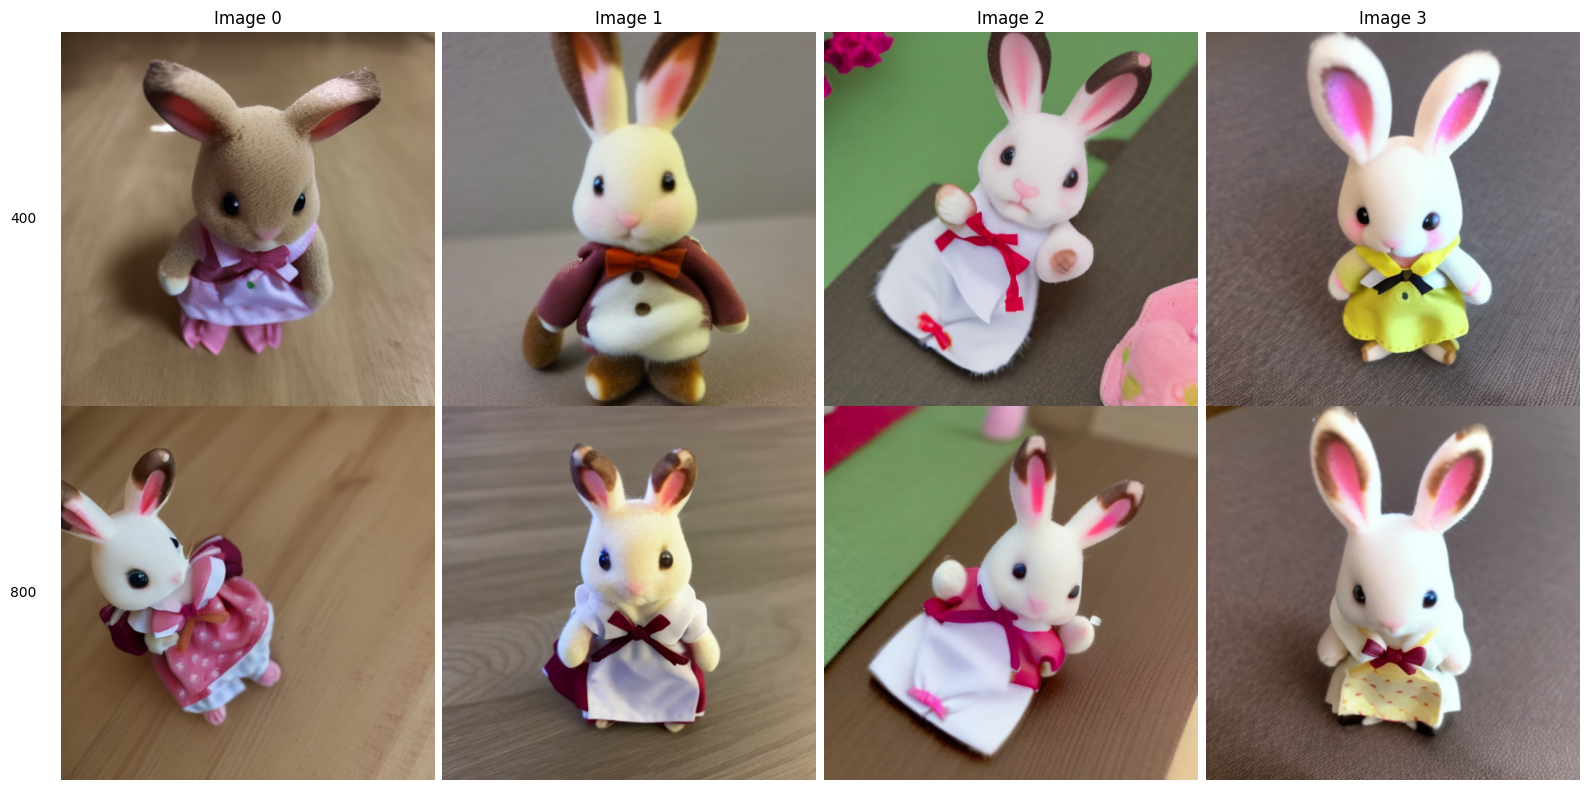

In [46]:
#@title 显示Sample
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = weights_dir
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))

scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})
print(axes)

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    print(image_folder)
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig(output_dir + '/samples.jpg', dpi=72)

# 上传HuggingFace

In [51]:
#@title 选择使用的weight
from glob import glob
from natsort import natsorted
import os
upload_weight_dir = natsorted(glob(weights_dir + os.sep + "*"))[-1]
print(upload_weight_dir)
print(f"[*] upload_weight_dir={upload_weight_dir}")

/content/drive/MyDrive/ZDreambooth/test-rabbit/weights/800
[*] upload_weight_dir=/content/drive/MyDrive/ZDreambooth/test-rabbit/weights/800


In [57]:
#@title 保存到huggingface
import os

if len(session_name) != 0 and save_to_hf != "none":
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  from huggingface_hub import delete_repo
  from IPython.display import display_markdown
  api = HfApi()
  
  name = api.whoami()["name"]
  repo_id = f"{name}/{session_name}"
  print(repo_id)

  # images_upload = os.listdir(save_path)
  # image_string = ""
  # for i, image in enumerate(images_upload):
  #     image_string = f'''{image_string}![image {i}](https://huggingface.co/{repo_id}/resolve/main/{dir}/{image})
# '''
  readme_text = f'''---
license: creativeml-openrail-m
tags:
- text-to-image
---
### {session_name} on Stable Diffusion via Dreambooth
model by {api.whoami()["name"]}

### 模型训练信息

* instance_prompt：{instance_prompt}
* save_sample_prompt：{save_sample_prompt}
* base_model：{pretrained_model_name_or_path}
* dataset：{dataset_model_name}


训练图
![instances](https://huggingface.co/{repo_id}/resolve/main/output/instances.jpg)

Sample图
{save_sample_prompt}
![{save_sample_prompt}](https://huggingface.co/{repo_id}/resolve/main/output/samples.png)

'''
# {image_string}
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(instance_prompt)
  text_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]

  try:
    delete_repo(repo_id=repo_id)
  except:
    None
  create_repo(repo_id, private=False)
  
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {repo_id} embeds and token"
  )
  api.upload_folder(
    folder_path=specific_weight_dir,
    path_in_repo="",
    repo_id=repo_id
  )

  if save_to_hf == "simple":
    api.upload_folder(
      folder_path=output_dir + "/instance_data_dir",
      path_in_repo="output/instance_data_dir",
      repo_id=repo_id
    )
    api.upload_file(
        path_or_fileobj=output_dir + "/instances.jpg",
        path_in_repo="output/instances.jpg",
        repo_id=repo_id)
    api.upload_file(
        path_or_fileobj=output_dir + "/samples.png",
        path_in_repo="output/samples.png",
        repo_id=repo_id)
  else:
    api.upload_folder(
      folder_path=output_dir,
      path_in_repo="output",
      repo_id=repo_id
    )

  display_markdown(f'''## Your concept was saved successfully. [Click here to access it](https://huggingface.co/{repo_id})''', raw=True)


hulefei/test-rabbit


Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1686416448.c5c0ec03dba7.1098.0:   0%|          | 0.00/6.78k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Your concept was saved successfully. [Click here to access it](https://huggingface.co/hulefei/test-rabbit)

# 验收

In [ ]:
#@title 选择使用的weight
from glob import glob

if weight_name == "":
    from natsort import natsorted
    import os
    temp = natsorted(glob(weights_dir + os.sep + "*"))
    weight_name = natsorted(glob(output_dir + os.sep + "*"))[-1]

specific_weight_dir = weights_dir + os.sep + weight_name
print(f"[*] specific_weight_dir={specific_weight_dir}")

[*] specific_weight_dir=/content/drive/MyDrive/ZDreambooth/test-rabbit/weights/800


In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = specific_weight_dir            # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive
print(model_path)

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

/content/drive/MyDrive/ZDreambooth/test-rabbit/weights/800


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
#@title Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

  0%|          | 0/24 [00:00<?, ?it/s]

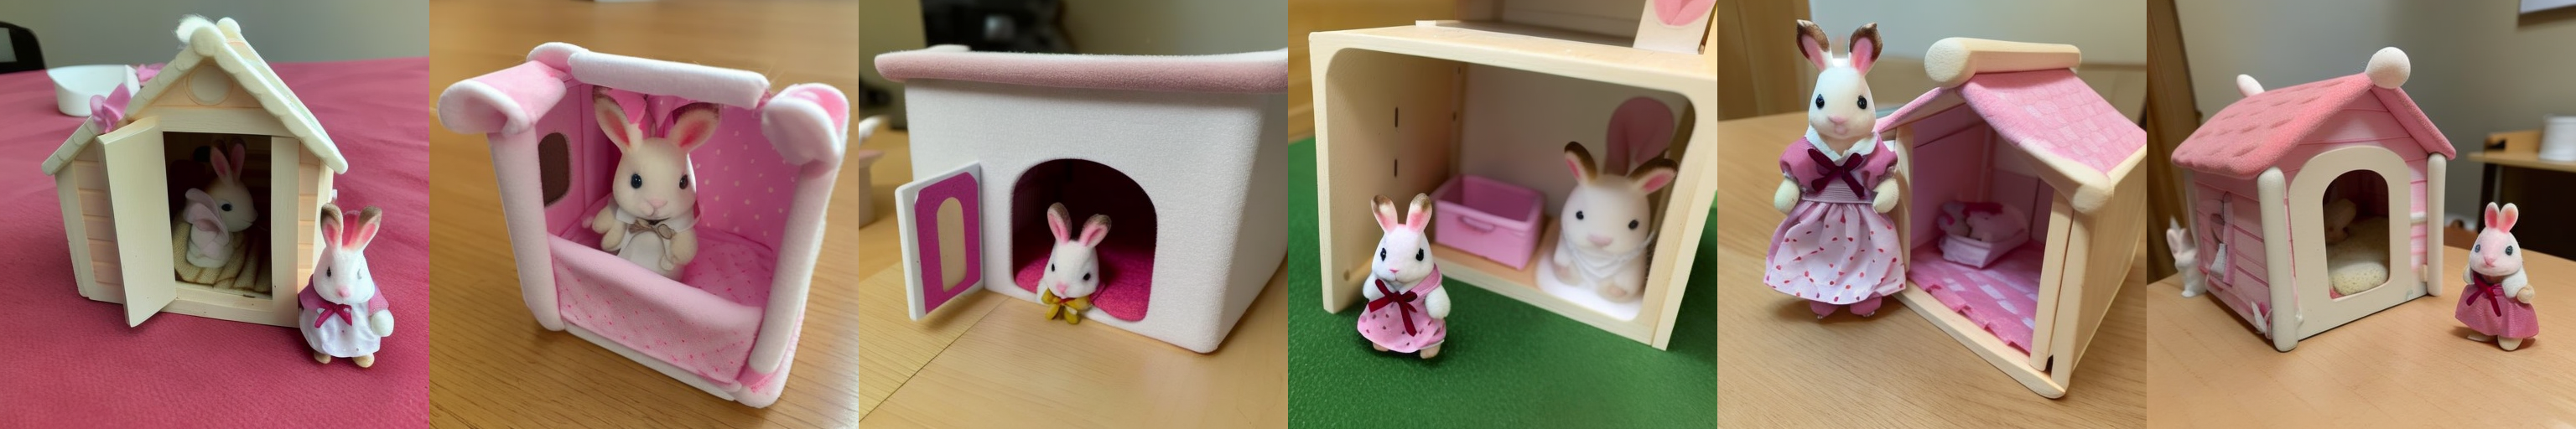

In [ ]:
#@title Run for generating images.

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

image_grid(images, 1, len(images))
# for img in images:
#     display(img)

In [ ]:
#@title Convert weights to ckpt to use in web UIs like AUTOMATIC1111.
ckpt_path = specific_weight_dir + "/model.ckpt"
print(ckpt_path)

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $specific_weight_dir  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

/content/drive/MyDrive/ZDreambooth/test-rabbit/weights/800/model.ckpt
Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/drive/MyDrive/ZDreambooth/test-rabbit/weights/800/model.ckpt
